# Курсовая работа по структурам и алгоритмам обработки данных
## Выполнил Карзанов Василий Васильевич, БФИ2202

In [162]:
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


### Реализация хэш-таблицы

In [163]:
class Node:
    def __init__(self, value):
        self.value = value
        self.next = None
        self.previous = None

class Deque:
    def __init__(self, *args):
        self.size = 0
        self.head = None
        self.end = None
        for x in args:
            self.pushBack(x)
            self.size += 1
    
    def isEmpty(self):
        return self.head is None
    
    def pushBack(self, value):
        self.size += 1
        tmp = Node(value)
        if self.isEmpty():
            self.head = tmp
            self.end = tmp
        else:
            self.end.next = tmp
            tmp.previous = self.end
            self.end = tmp
    
    def pushTop(self, value):
        self.size += 1
        tmp = Node(value)
        if self.isEmpty():
            self.head = tmp
            self.end = tmp
        else:
            self.head.previous = tmp
            tmp.next = self.head
            self.head = tmp

    def popTop(self):
        if self.isEmpty():
            return None
        self.size -= 1
        tmp = self.head.value
        if self.size == 0:
            self.head = None
            self.end = None
            return tmp
        self.head = self.head.next
        if self.head is not None:
            self.head.previous = None
        return tmp
    
    def popBack(self):
        if self.isEmpty():
            return None
        self.size -= 1
        tmp = self.end.value
        if self.size == 0:
            self.head = None
            self.end = None
            return tmp
        self.end = self.end.previous
        if self.end is not None:
            self.end.next = None
        return tmp

In [164]:
class Hash:

    def __init__(self, size):
        self.size = size
        self.keys = [None for _ in range(self.size)]
        self.values = [None for _ in range(self.size)]
        self.hashFunc = lambda key: (sum([ord(x) for x in key]) + len(key)) % self.size
    
    def put(self, key, value):
        hashkey = self.hashFunc(key)
        if self.keys[hashkey] is None:
            self.keys[hashkey] = Deque()
            self.values[hashkey] = Deque()
            self.keys[hashkey].pushBack(key)
            self.values[hashkey].pushBack(value)
        else:
            key_pointer = self.keys[hashkey].head
            value_pointer = self.values[hashkey].head
            flag = True
            while key_pointer is not None:
                if key_pointer.value == key:
                    value_pointer.value = value
                    flag = False
                    break
                else:
                    key_pointer = key_pointer.next
                    value_pointer = value_pointer.next
            if flag:
                self.keys[hashkey].pushBack(key)
                self.values[hashkey].pushBack(value)
        

    def get(self, key):
        hashkey = self.hashFunc(key)
        if self.keys[hashkey] is None:
            return None
        key_pointer = self.keys[hashkey].head
        value_pointer = self.values[hashkey].head
        for i in range (self.keys[hashkey].size):
            if key_pointer.value == key:
                return value_pointer.value
            key_pointer = key_pointer.next
            value_pointer = value_pointer.next
        return None
    
    def labels(self):
        res = []
        for x in self.keys:
            if x is not None:
                pointer = x.head
                while pointer is not None:
                    res.append(pointer.value)
                    pointer = pointer.next
        return res
        

### Реализация извлечения данных из файла в формате csv

In [184]:
import csv

def get_data(file_name):
    
    htdb = Hash(128)

    with open(file_name, 'r', encoding= 'utf-8-sig') as file:
        reader = csv.reader(file, delimiter=";")
        
        for row in reader:
            try:    
                order_num, order_date, product_name, product_category, sold_qty, unit_price, total_cost = row
                sold_qty, total_cost = int(sold_qty), int(total_cost)
            except:
                continue

            if not all([order_num, order_date, product_name, product_category, sold_qty, unit_price, total_cost]):
                continue

            if htdb.get(product_name) is not None:
                product_row = htdb.get(product_name)
                htdb.put(product_name, [product_category, sold_qty + product_row[1], total_cost + product_row[2]])
            else:
                htdb.put(product_name, [product_category, sold_qty, total_cost])

    return htdb

### Реализация анализа данных о продажах магазина

In [185]:
def analyze_data(data):
    total_revenue = 0
    max_sold = 0
    best_by_sold = []
    max_revenue = 0
    best_by_revenue = []

    for product_name in data.labels():
        product_row = data.get(product_name)

        total_revenue += product_row[2]

        if max_sold < product_row[1]:
            max_sold = product_row[1]
            best_by_sold = [product_name]
        elif max_sold == product_row[1]:
            best_by_sold += [product_name]
        
        if max_revenue < product_row[2]:
            max_revenue = product_row[2]
            best_by_revenue = [product_name]
        elif max_revenue == product_row[2]:
            best_by_revenue += [product_name]
    
    results = []

    for product_name in data.labels():
        product_row = data.get(product_name)

        results.append([product_name, product_row[1], product_row[2] / total_revenue])

    return total_revenue, [best_by_sold, max_sold], [best_by_revenue, max_revenue], results


### Реализация сортировки массива данных

In [186]:
def sort(data, low, high, col):
    if low < high:
        p = partition(data, low, high, col)
        sort(data, low, p, col)
        sort(data, p+1, high, col)

def partition(data, low, high, col):
    pivot = data[(low+high) // 2][col]
    i = low
    j = high
    while True:
        while data[i][col] > pivot:
            i += 1
        while data[j][col] < pivot:
            j -= 1
        if i >= j:
            return j
        data[i], data[j] = data[j], data[i]
        i += 1
        j -= 1

### Отчёт о продажах магазина в текстовом виде

In [187]:
total_revenue, best_sold, best_revenue, data = analyze_data(get_data("sells.csv"))

col = input("По какому значению сортировать товары:\n1 - по проданному количеству\n2 - по доле в выручке")
if col == "1" or col == "2":
    col = int(col)
else:
    col = 0
sort(data, 0, len(data) - 1,  col)

print("Отчёт по продажам:\n")

print("Общая выручка магазина равна", total_revenue, "руб.")

if len(best_sold[0]) > 1:
    products = best_sold[0][0]
    for i in best_sold[0][1:]:
        products += ", " + i
    print("Товары с наибольшим количеством проданного: " + products + ", продано " + str(best_sold[1]) + " штук каждого.", sep = '')
else:
    print("Товар с наибольшим количеством проданного: " + best_sold[0][0] + ", продано " + str(best_sold[1]) + " штук.", sep = '')

if len(best_revenue[0]) > 1:
    products = best_revenue[0][0]
    for i in best_revenue[0][1:]:
        products += ", " + i
    print("Товары с наибольшей стоимостью проданного: " + products + ", продано на " + str(best_revenue[1]) + " руб. каждого.", sep = '')
else:
    print("Товар с наибольшей стоимостью проданного: " + best_revenue[0][0] + ", продано на " + str(best_revenue[1]) + " руб.", sep = '')

print("\nОтчёт по отварам:\nНаименование товара\t\tПроданное количество\tДоля в выручке")
for row in data:
    print(row[0] + ("\t" * (4 - ((len(row[0]))//8))) + str(row[1]) + "\t" * (3 - (len(str(row[1]))//8)) + (str(row[2] * 100) + "%"))


Отчёт по продажам:

Общая выручка магазина равна 122496650 руб.
Товар с наибольшим количеством проданного: Верёвка, продано 13842 штук.
Товар с наибольшей стоимостью проданного: Лимонад, продано на 16005000 руб.

Отчёт по отварам:
Наименование товара		Проданное количество	Доля в выручке
Лимонад				10670			13.065663428346816%
Футболка			10451			12.797492829395743%
Утюг				9717			11.898692739760639%
Чайник				5852			9.554547001897602%
Худи				4146			8.461455884711949%
Настольная лампа		10000			8.16348855254409%
Гель для стирки			8852			7.226320066712029%
Верёвка				13842			5.649950427215765%
Брюки				1251			4.085009671693063%
Колбаса				8172			3.3356014225695154%
Удлинитель			10045			3.2800897004122156%
Носки				10346			2.5337835769386348%
Шампунь				10167			2.4899456434114726%
Микроволновая печь		726			2.370677075658804%
Средство для мытья посуды	10177			1.661596459984824%
Пылесос				287			1.1714606072900768%
Мыло				13713			1.119459185210371%
Контейнер пищевой		10440			0.85226820488560

### Графическое представление распределения выручки магазина

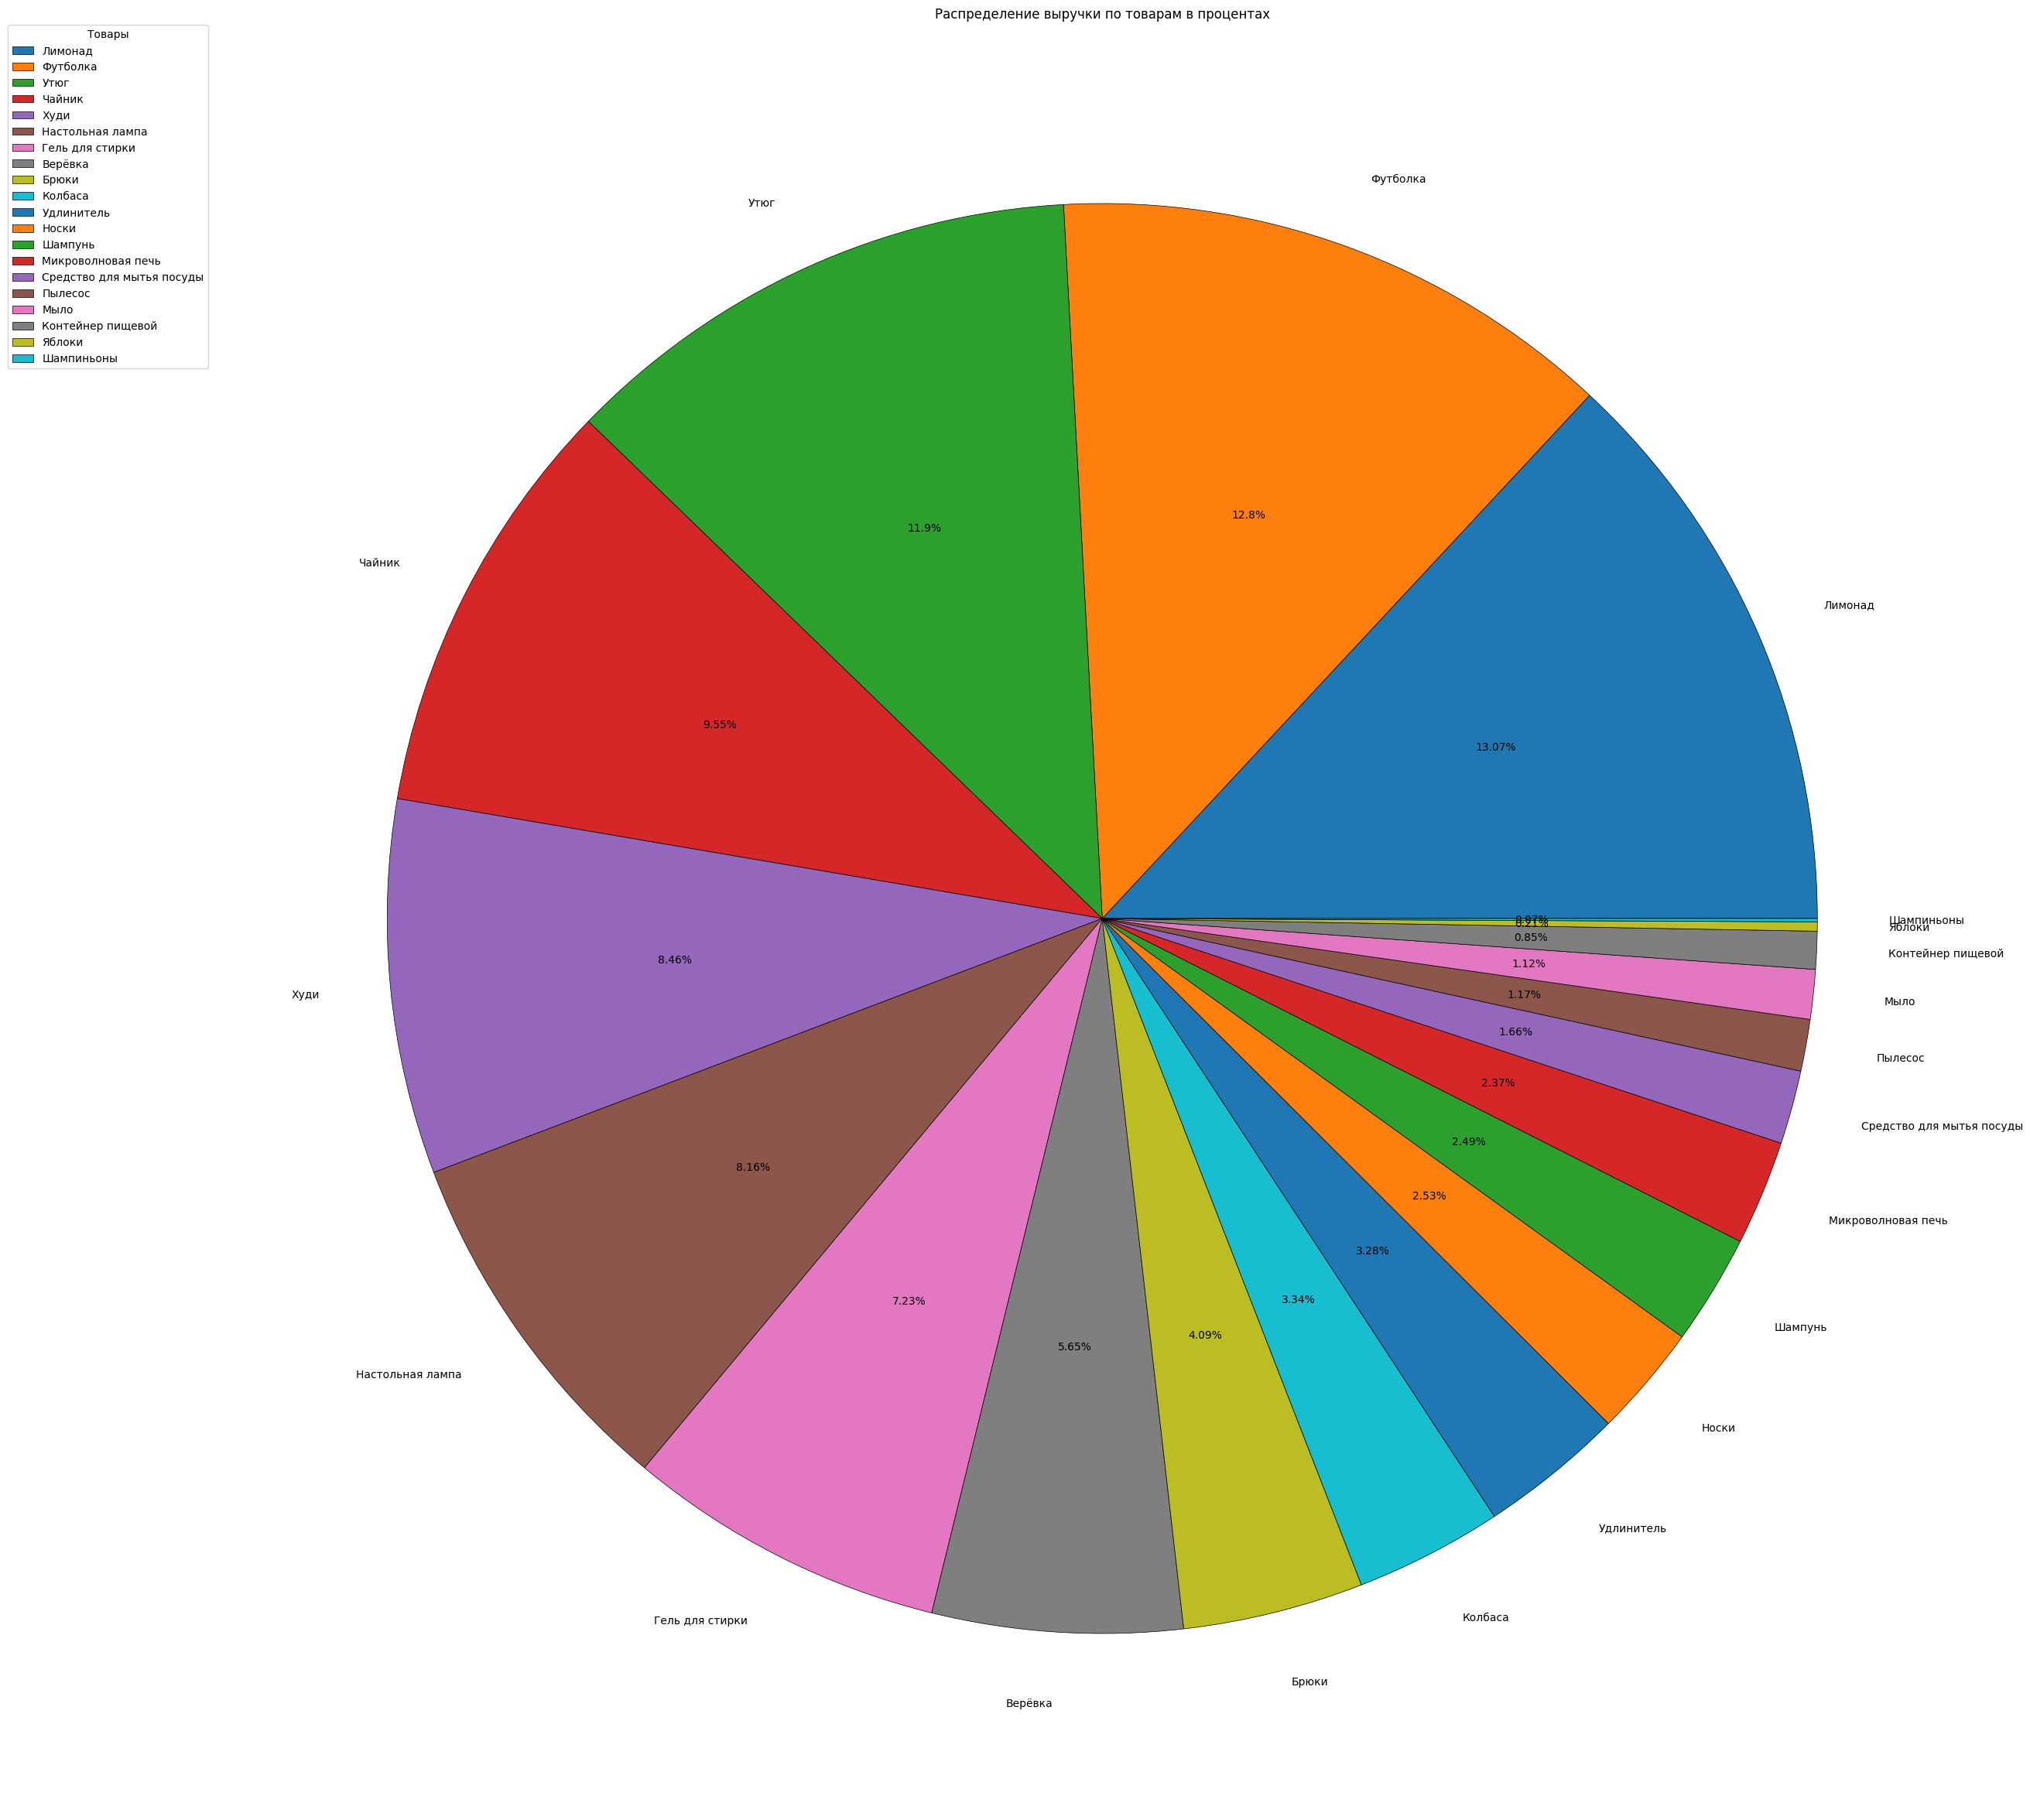

In [188]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30, 30))
plt.title("Распределение выручки по товарам в процентах")
plt.pie([x[2] for x in data], labels=[x[0] for x in data], autopct=lambda x: str(round(x, 2)) + '%', wedgeprops={'linewidth': 0.5, 'edgecolor': "black"})
plt.legend(labels=[x[0] for x in data], title="Товары", bbox_to_anchor=(0, 1), loc='upper right', borderaxespad=0, ncol=1)